#Setup

In [1]:
pip install openeo

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
WorkDir = "/content/drive/MyDrive/tensorflow_project/Satellite Image Analysis/"

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import date
from datetime import datetime
from tqdm import tqdm
import json
import requests
import openeo

In [5]:
import os
os.chdir(WorkDir)

#Point of interest

In [6]:
location = pd.read_csv('data/water-quality/coupeville-wharf-mooring_dataset.csv')
location.head()

,Dataset,Latitude,Longitude,Date,Time,Temperature (°C),pH,Dissolved Oxygen (mg/L),Turbidity (NTU),Conductivity (S/m)
0,coupeville-wharf-mooring-raw-data-output,48.222825,-122.688425,2023-01-17,12:45:00,7.9765,7.72,9.094,0.375,2.38581
1,coupeville-wharf-mooring-raw-data-output,48.222825,-122.688425,2023-01-17,13:00:00,7.9448,7.75,9.309,0.389,2.35198
2,coupeville-wharf-mooring-raw-data-output,48.222825,-122.688425,2023-01-17,13:15:00,7.9236,7.77,9.449,0.394,2.32446
3,coupeville-wharf-mooring-raw-data-output,48.222825,-122.688425,2023-01-17,13:30:00,7.9577,7.77,9.436,0.346,2.34717
4,coupeville-wharf-mooring-raw-data-output,48.222825,-122.688425,2023-01-17,13:45:00,7.9722,7.77,9.356,0.583,2.36719


In [7]:
location.groupby(['Latitude', 'Longitude']).count()

,,Dataset,Date,Time,Temperature (°C),pH,Dissolved Oxygen (mg/L),Turbidity (NTU),Conductivity (S/m)
Latitude,Longitude,,,,,,,,
48.222825,-122.688425,26278,26278,26278,26278,26278,26278,26278,26278


In [8]:
len(location)

26278

In [9]:
list(location.Date)[0], list(location.Date)[-1]

('2023-01-17', '2023-10-18')

In [10]:
date_format = "%Y-%m-%d"

a = datetime.strptime(list(location.Date)[0], date_format)
b = datetime.strptime(list(location.Date)[-1], date_format)

delta = b - a

print(f'Number of days = {delta.days}')

Number of days = 274


#Search Satellite images

In [11]:
def BuildSquare(lon, lat, delta):
    c1 = [lon + delta, lat + delta]
    c2 = [lon + delta, lat - delta]
    c3 = [lon - delta, lat - delta]
    c4 = [lon - delta, lat + delta]
    geometry = {"type": "Polygon", "coordinates": [[ c1, c2, c3, c4, c1 ]]}
    return geometry

0.01 degree = 1.111 km

In [9]:
geometry = BuildSquare(location.Longitude[0], location.Latitude[0], 0.001)
geometry

{'type': 'Polygon',
 'coordinates': [[[-122.6484251, 48.262825299999996],
   [-122.6484251, 48.1828253],
   [-122.72842510000001, 48.1828253],
   [-122.72842510000001, 48.262825299999996],
   [-122.6484251, 48.262825299999996]]]}

Connect to the API Data Center

In [12]:
connection = openeo.connect("openeo.dataspace.copernicus.eu")

In [13]:
# List collections available on the openEO back-end
connection.list_collection_ids()

['SENTINEL3_OLCI_L1B',
 'SENTINEL3_SLSTR',
 'SENTINEL_5P_L2',
 'SENTINEL2_L1C',
 'SENTINEL2_L2A',
 'SENTINEL1_GRD',
 'COPERNICUS_30']

In [14]:
# Get detailed metadata of a certain collection
connection.describe_collection("SENTINEL2_L2A")

{'assets': {'thumbnail': {'href': 'https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2022/07/tallinn_estonia/24383281-1-eng-GB/Tallinn_Estonia_pillars.jpg',
   'roles': ['thumbnail'],
   'title': 'Sentinel 2 L2A',
   'type': 'image/png'}},
 'cube:dimensions': {'bands': {'type': 'bands',
   'values': ['B01',
    'B02',
    'B03',
    'B04',
    'B05',
    'B06',
    'B07',
    'B08',
    'B8A',
    'B09',
    'B11',
    'B12',
    'WVP',
    'AOT',
    'SCL',
    'sunAzimuthAngles',
    'sunZenithAngles',
    'viewAzimuthMean',
    'viewZenithMean']},
  't': {'extent': ['2015-07-04T00:00:00Z', None], 'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-180, 180],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-56, 83],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'}},
 'description': 'SENTINEL-2 is a wide-swath, high-resolution, multi-spectral imaging mission, supporting Copernicus Land Monitoring studies, including the monitoring of vegetation, soil and water cover, as well as observation of inland waterways and coastal areas. The SENTINEL-2 Multispectral Instrument (MSI) samples 13 spectral bands: four bands at 10 metres, six bands at 20 metres and three bands at 60 metres spatial resolution.\n The level 2A data is atmospherically corrected using Sen2Cor.',
 'extent': {'spatial': {'bbox': [[-180, -56, 180, 83]]},
  'temporal': {'interval': [['2015-07-04T00:00:00Z', None]]}},
 'id': 'SENTINEL2_L2A',
 'keywords': ['COPERNICUS',
  'ESA',
  'Orthoimagery',
  'Sentinel-2',
  'MSI',
  'Level-2A',
  'Radiometry',
  'Plant Resource',
  'TOC'],
 'license': 'proprietary',
 'links': [{'href': 'https://sentinels.copernicus.eu/documents/247904/690755/Sentinel_Data_Legal_Notice',
   'rel': 'license',
   'type': 'application/pdf'},
  {'href': 'https://documentation.dataspace.copernicus.eu/Data/Sentinel2.html',
   'rel': 'alternate',
   'type': 'application/html'},
  {'href': 'https://dataspace.copernicus.eu/browser/?zoom=11&lat=45.36638&lng=12.49832&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2F28b654e7-8912-4e59-9e58-85b58d768b3a&datasetId=S2_L2A_CDAS&fromTime=2023-02-07T00%3A00%3A00.000Z&toTime=

Click the link and confirm authentication

In [15]:
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.1/' with OidcBearerAuth>

0.0005 = 50 m

In [16]:
delta = 0.0005
# start_date = list(location.Date)[0]
# end_date = list(location.Date)[-1]
start_date = '2023-10-01'
end_date = '2023-10-18'

In [17]:
datacube = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=BuildSquare(location.Longitude[0], location.Latitude[0], delta),
    temporal_extent = [start_date, end_date],
    bands=["B04", "B03", "B02"],
    max_cloud_cover=50
)

#Download & Process Satellite images

By filtering as early as possible (directly in load_collection() in this case),

we make sure the back-end only loads the data we are interested in and avoid incurring unneeded costs.

In [134]:
#From this data cube, we can now select the individual bands with the DataCube.band() method and rescale the digital number values to physical reflectances:
# blue = datacube.band("B02") * 0.0001
green = datacube.band('B03')#*0.0001
# red = datacube.band("B04") * 0.0001
nir = datacube.band("B08")# * 0.0001

In [84]:
# We now want to compute the enhanced vegetation index and can do that directly with these band variables:
evi_cube = 2.5 * (nir - red) / (nir + 6.0 * red - 7.5 * blue + 1.0)

In [135]:
ndwi_cube = (green - nir) / (nir + green)

In [105]:
# evi_composite = evi_cube.max_time()
ndwi_composites = ndwi_cube.max_time()

In [18]:
datacube

In [19]:
datacube.download("data/satellite-images/raw.nc")

In [191]:
datacube.download("data/satellite-images/original.tiff")

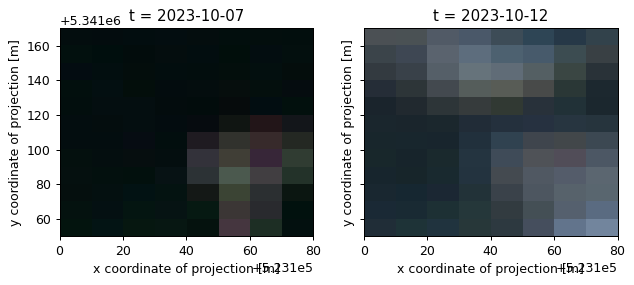

In [20]:
import xarray

ds = xarray.load_dataset("data/satellite-images/raw.nc")
# Convert xarray DataSet to a (bands, t, x, y) DataArray
data = ds[["B04", "B03", "B02"]].to_array(dim="bands")

fig, axes = plt.subplots(ncols=2, figsize=(8, 3), dpi=90, sharey=True)
data[{"t": 0}].plot.imshow(vmin=0, vmax=2000, ax=axes[0])
data[{"t": -1}].plot.imshow(vmin=0, vmax=2000, ax=axes[1]);

In [21]:
data.shape

(3, 2, 12, 8)

#Dataset Creation

load location data

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Custom TB Handler failed, unregistering
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-721d27149c02>", line 1, in <cell line: 1>
    location = pd.read_csv('data/water-quality/coupeville-wharf-mooring_dataset.csv')
  File "/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py", line 331, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 950, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 605, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 1442, i